In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn import model_selection

In [2]:
import bin_tree
import bin_forest

# ДЗ №5 Гладышев В.В.

## Задание № 1

Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 
   
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [3]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

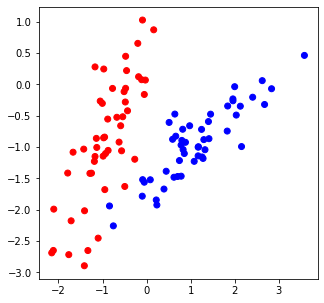

In [4]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(5,5))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [5]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)


Точность случайного леса из 1 деревьев на обучающей выборке: 95.714
Точность случайного леса из 1 деревьев на тестовой выборке: 90.000


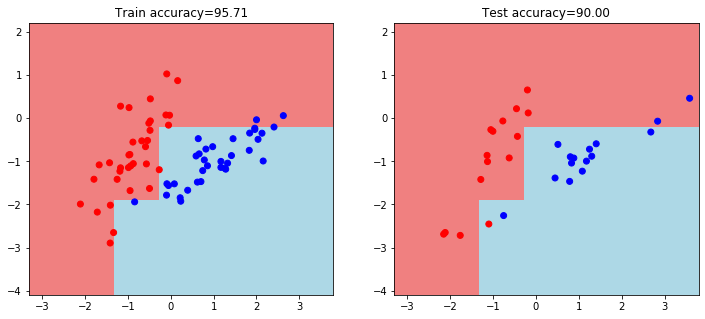


Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 93.333


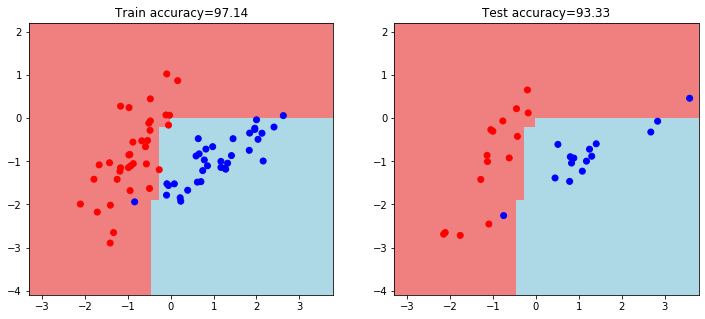


Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 93.333


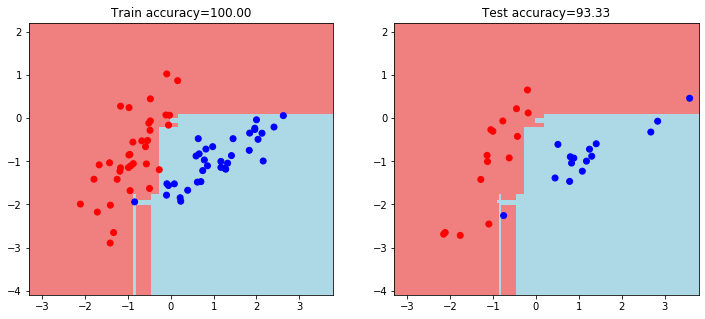


Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


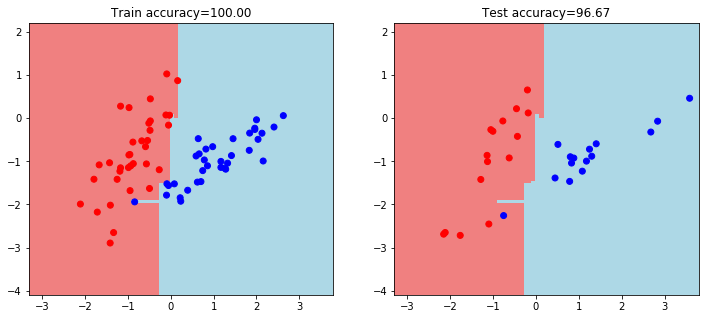

In [6]:
n_trees_list = [1, 3, 10, 50]
train_accuracy_list = []
test_accuracy_list = []

for n_trees in n_trees_list:
    my_forest = bin_forest.random_forest(train_data, train_labels, n_trees)
    train_answers = bin_forest.tree_vote(my_forest, train_data)
    test_answers = bin_forest.tree_vote(my_forest, test_data)
    train_accuracy = bin_forest.accuracy_metric(train_labels, train_answers)
    print(f'\nТочность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    train_accuracy_list.append(train_accuracy)
    test_accuracy = bin_forest.accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    test_accuracy_list.append(test_accuracy)
    
    plt.figure(figsize = (12, 5))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = bin_forest.get_meshgrid(train_data)
    mesh_predictions = np.array(bin_forest.tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

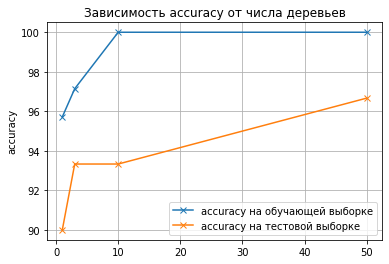

In [7]:
#plt.xticks([0, 1, 2, 3])
plt.plot(n_trees_list, train_accuracy_list, marker='x')
plt.plot(n_trees_list, test_accuracy_list, marker='x')

plt.title("Зависимость accuracy от числа деревьев")
plt.ylabel("accuracy")
plt.legend(labels=["accuracy на обучающей выборке", "accuracy на тестовой выборке"])
plt.grid()
plt.show()

#### Сложность гиперплоскости увеличивается с ростом числа деревьев (при изменении числа деревьев от 10 до 50 это не вполне очевидно). С ростом числа деревьев гиперплоскость точнее подстраивается под обучающую выборку. Перебучение присутствует, но сростом числа деревьев точность на тестовой выборке продолжает повышаться.

## Задание № 2

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [8]:
classification_data, classification_labels = datasets.make_classification(n_samples = 100, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [9]:
def get_bootstrap_OOB_by_data(data, labels, N):
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []

    index_OOB_by_data = [set() for _ in range(n_samples)]
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            index_OOB_by_data[sample_index].add(i)
        bootstrap.append((b_data, b_labels))
        
    return bootstrap, index_OOB_by_data

In [10]:
def random_forest_OOB_by_data(data, labels, n_trees):
    forest = []
    oob = []
    bootstrap, ind_OOB_by_data = get_bootstrap_OOB_by_data(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(bin_forest.build_tree(b_data, b_labels))
        
    set_ind =  set(range(n_trees))
#     print(ind_OOB_by_data)
#     print("\nРазность:")
    for ind_dat, dt in enumerate(ind_OOB_by_data):
        correct = 0
        diff = set_ind.difference(dt)
#         print(ind_dat, diff)
        if len(diff):
            for tree_ind in diff:
                pred = bin_forest.classify_object(data[ind_dat], forest[tree_ind])
#                 print(pred)
                if labels[ind_dat] == pred:
                    correct += 1
            oob.append(correct / float(len(diff)) * 100.0)
            print("acc for data str {}: {:.2f}".format(ind_dat + 1, oob[len(oob)-1]))            

    return forest, np.mean(oob)

In [11]:
n_trees = 10
forest_OOB_by_data, oob = random_forest_OOB_by_data(classification_data, classification_labels, n_trees)

acc for data str 1: 100.00
acc for data str 2: 100.00
acc for data str 3: 100.00
acc for data str 4: 100.00
acc for data str 5: 100.00
acc for data str 6: 100.00
acc for data str 7: 100.00
acc for data str 8: 50.00
acc for data str 9: 100.00
acc for data str 10: 66.67
acc for data str 11: 100.00
acc for data str 12: 100.00
acc for data str 13: 100.00
acc for data str 14: 100.00
acc for data str 15: 100.00
acc for data str 16: 100.00
acc for data str 17: 75.00
acc for data str 18: 100.00
acc for data str 19: 100.00
acc for data str 20: 100.00
acc for data str 21: 100.00
acc for data str 22: 25.00
acc for data str 23: 100.00
acc for data str 24: 100.00
acc for data str 25: 100.00
acc for data str 26: 75.00
acc for data str 27: 80.00
acc for data str 28: 100.00
acc for data str 29: 100.00
acc for data str 30: 100.00
acc for data str 31: 100.00
acc for data str 33: 100.00
acc for data str 34: 100.00
acc for data str 35: 100.00
acc for data str 36: 100.00
acc for data str 37: 100.00
acc for

In [12]:
print("OOB: {:.2f}".format(oob))

OOB: 89.97


In [13]:
def get_bootstrap_OOB_by_trees(data, labels, N):
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []

    index_OOB_by_trees = [set() for _ in range(N)]
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            index_OOB_by_trees[i].add(sample_index)
        bootstrap.append((b_data, b_labels))
        
    return bootstrap, index_OOB_by_trees

In [14]:
def random_forest_OOB_by_trees(data, labels, n_trees):
    forest = []
    oob = []
    bootstrap, ind_OOB_by_trees = get_bootstrap_OOB_by_trees(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(bin_forest.build_tree(b_data, b_labels))
        
    set_ind =  set(range(data.shape[0]))
#     print(ind_OOB_by_trees)
#     print("\nРазность:")
    for ind_tree, dt in enumerate(ind_OOB_by_trees):
        correct = 0
        diff = set_ind.difference(dt)
#         print(ind_tree, diff)
        if len(diff):
            for data_ind in diff:
                pred = bin_forest.classify_object(data[data_ind], forest[ind_tree])
#                 print(pred)
                if labels[data_ind] == pred:
                    correct += 1
            oob.append(correct / float(len(diff)) * 100.0)
            print("acc for tree {}: {:.4f}".format(ind_tree + 1, oob[len(oob)-1]))            

    return forest, np.mean(oob)

In [15]:
forest_OOB_by_trees, oob_t = random_forest_OOB_by_trees(classification_data, classification_labels, n_trees)

acc for tree 1: 92.3077
acc for tree 2: 84.2105
acc for tree 3: 94.4444
acc for tree 4: 91.1765
acc for tree 5: 86.4865
acc for tree 6: 97.5610
acc for tree 7: 90.9091
acc for tree 8: 93.5484
acc for tree 9: 93.5484
acc for tree 10: 81.0811


In [16]:
print("OOB by trees: {:.2f}".format(oob_t))

OOB by trees: 90.53


In [17]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.37,
                                                                                     random_state = 1)

In [18]:
my_forest = bin_forest.random_forest(train_data, train_labels, n_trees)
train_answers = bin_forest.tree_vote(my_forest, train_data)
test_answers = bin_forest.tree_vote(my_forest, test_data)
train_accuracy = bin_forest.accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = bin_forest.accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.413
Точность случайного леса из 10 деревьев на тестовой выборке: 91.892



## Задание № 3

Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [19]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов    
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:
            entropy += p * np.log2(p)
        
    return entropy * (-1)

In [20]:
def quality_e(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [21]:
def find_best_split_e(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_e(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [22]:
def build_tree_e(data, labels):

    quality, t, index = find_best_split_e(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return bin_tree.Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_e(true_data, true_labels)
    false_branch = build_tree_e(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return bin_tree.Node(index, t, true_branch, false_branch)

In [23]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [24]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [25]:
tree_ent = build_tree_e(train_data, train_labels)

In [26]:
bin_tree.print_tree(tree_ent)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [27]:
train_answers = bin_tree.predict(train_data, tree_ent)
answers = bin_tree.predict(test_data, tree_ent)
train_accuracy = bin_tree.accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [28]:
test_accuracy = bin_tree.accuracy_metric(test_labels, answers)
test_accuracy

100.0